**This Exercise shows how to use Google colab to apply regression models.**
**Copy the Colab notebook and data to your google drive before proceeding.**

Step 1: Connect Google drive that stores the data with your Google Colab Notebook

In [ ]:
import numpy as np
import numpy.matlib as matlib
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [ ]:
# Replace the ID with ID of file you want to access
# To get this ID, right-click on the name of the appropriate file in your 
downloaded = drive.CreateFile({'id':'1Z6MYK_-FV7J0aTVxoPnjI-E3DdbwMDHG'}) 
downloaded.GetContentFile('time_series_covid_19_confirmed.csv') 

Step 2: Read the Data and verify its format!

In [ ]:
import pandas as pd
data = pd.read_csv('time_series_covid_19_confirmed.csv') 
print("The shape of data=",data.shape)
data.head()

The shape of data= (266, 225)


Province/State Country/Region       Lat  ...  8/27/20  8/28/20  8/29/20
0            NaN    Afghanistan  33.93911  ...    38129    38140    38143
1            NaN        Albania  41.15330  ...     9083     9195     9279
2            NaN        Algeria  28.03390  ...    43016    43403    43781
3            NaN        Andorra  42.50630  ...     1098     1124     1124
4            NaN         Angola -11.20270  ...     2415     2471     2551

[5 rows x 225 columns]

Step 3: Original data has [266x225] dimensions. Let's use only 50 rows and 100 columns.

In [ ]:
rows=50
cols=100
data_new=data.iloc[0:rows,4:cols+4]
print(data_new.shape)

(50, 100)


In [ ]:
#view the sub-sectioned data
data_new.head()

1/22/20  1/23/20  1/24/20  1/25/20  ...  4/27/20  4/28/20  4/29/20  4/30/20
0        0        0        0        0  ...     1703     1828     1939     2171
1        0        0        0        0  ...      736      750      766      773
2        0        0        0        0  ...     3517     3649     3848     4006
3        0        0        0        0  ...      743      743      743      745
4        0        0        0        0  ...       27       27       27       27

[5 rows x 100 columns]

Step 4: Convert the Tablular data to format {X,Y}, where X={Longitude, Latitude, Date}, Y={#infected}

In [ ]:
# Finding the date indices
import matplotlib.pyplot as plt
data_row=data_new.sum(axis=0)
days=range(0,data_row.shape[0])
days_mat=matlib.repmat(np.array(days),data_new.shape[0],1)
print(days_mat.shape)

(50, 100)


In [ ]:
# Let's create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
X=np.zeros((days_mat.shape[0]*days_mat.shape[1],3))
Y=np.zeros((days_mat.shape[0]*days_mat.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_new=np.array(data_new)
for r in range(days_mat.shape[0]): #all locations
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],0]=lat_long[r,0]*np.ones((days_mat.shape[1],)) #setting Latitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],1]=lat_long[r,1]*np.ones((days_mat.shape[1],)) #setting Longitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],2]=np.reshape(days,(days_mat.shape[1],)) #setting the date
  Y[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1]]=np.reshape(data_new[r,:],((days_mat.shape[1],1)))

In [ ]:
print(np.shape(X))
#Data Preparation is Done!

(5000, 3)


Step 5: Let's Plot the Data to see the converted Data format!

(5000, 3)


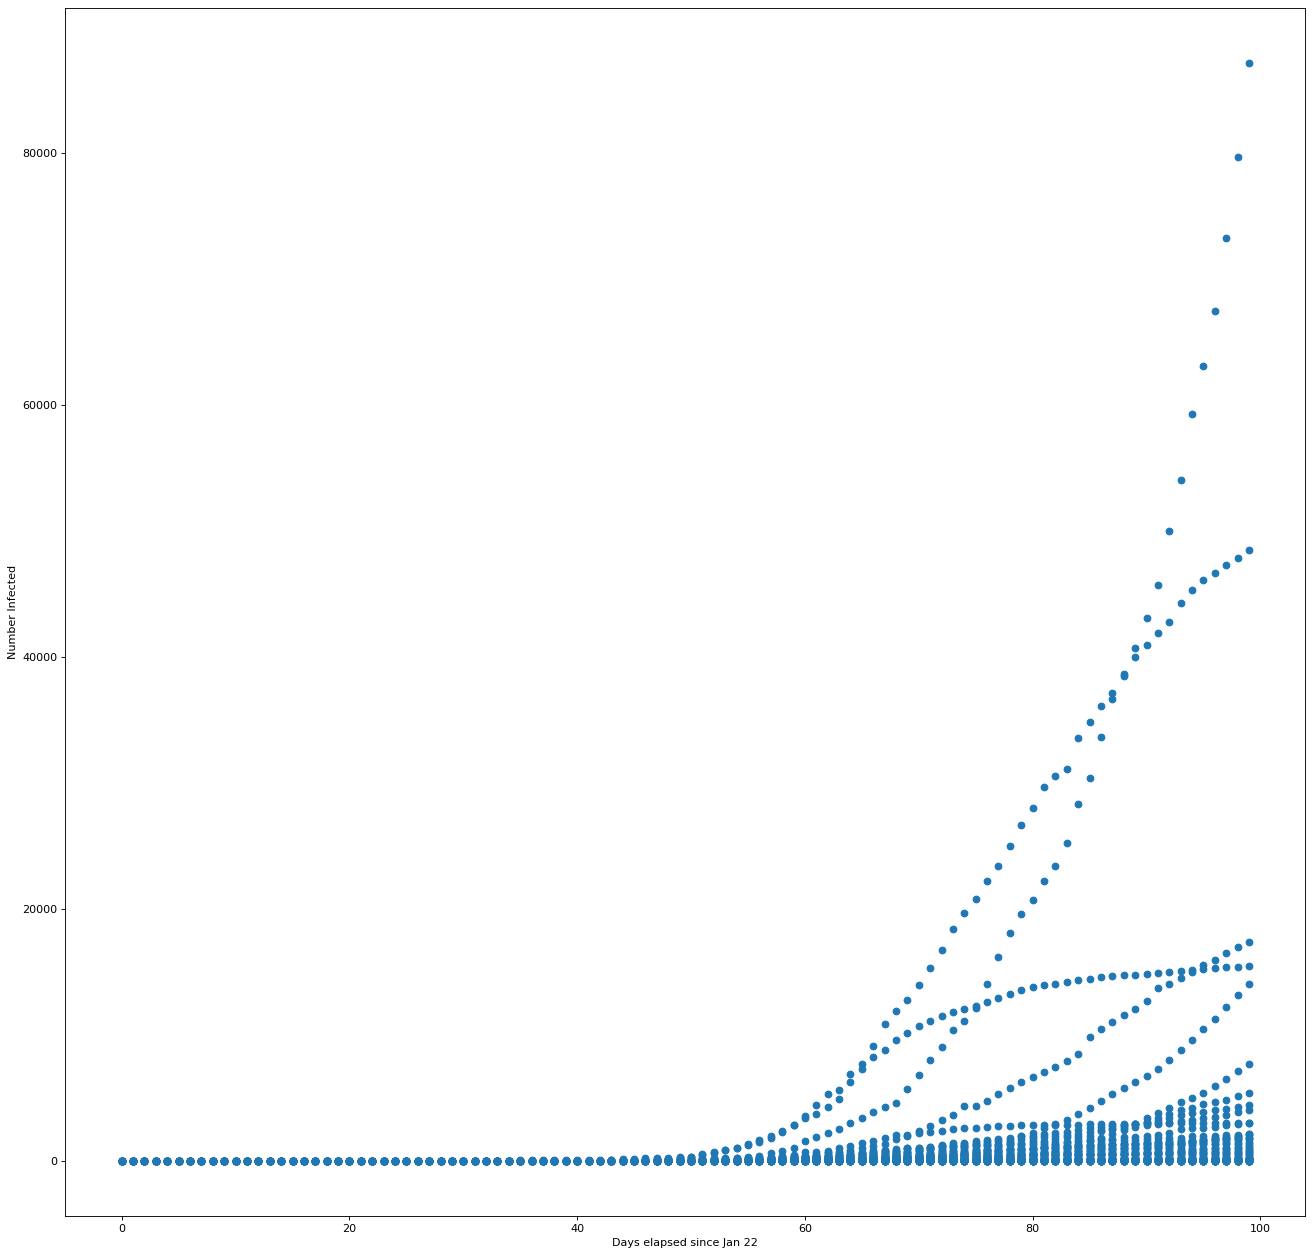

In [ ]:
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.xlabel('Days elapsed since Jan 22')
plt.ylabel('Number Infected')
print(np.shape(X))

Step 6: Let's spilt the data to training and test (70% train, 30% test)

In [ ]:
# Goal 1: Fit regression model for (days vs infections)
from sklearn.model_selection import train_test_split
# Split data into train and test
X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Step 7: Let's fit Polynomial features of degree 3 to the features. This results in dimensions going from 3 to 20!

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3)
# Transform both the train and test data
X_train = poly.fit_transform(X_train_1)
X_test = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf = LinearRegression()
# Fit the model on train data only
clf.fit(X_train, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 20)
Linear Regression Coefficients are= [[ 0.00000000e+00  1.49472285e+00 -1.77011169e+01 -7.44377620e+00
  -2.62371164e+00 -1.66783679e-01 -1.32523607e+00  1.32613637e-01
   1.60019698e-01 -5.80740444e-01  4.74622499e-02  8.72080430e-03
   4.50831003e-02 -2.04127549e-03  1.26028661e-02  2.75122310e-03
   2.97102909e-04 -9.33173379e-04 -3.45730697e-03  9.73845530e-03]]
constant coefficient= [515.00766133]


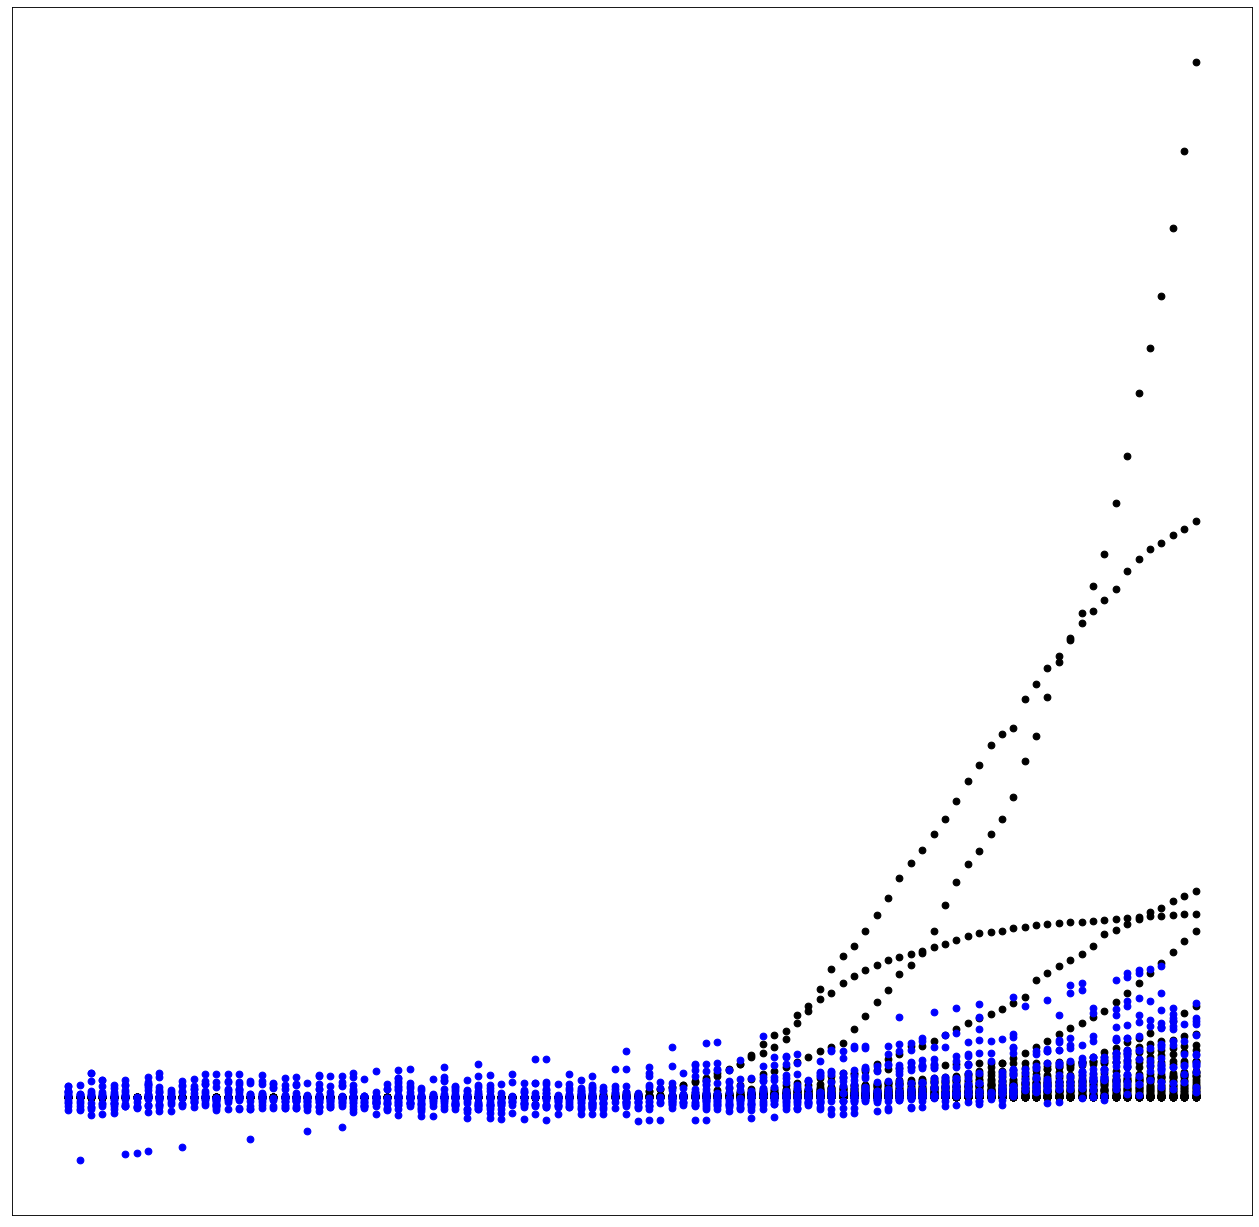

In [ ]:
# Predict regression outcome on test data
y_pred = clf.predict(X_test)
# next plot predictions
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

In the image above, black points are training and blue ones are test!

In [ ]:
from sklearn.metrics import mean_squared_error as mse
print(mse(y_test, y_pred))

20560548.002745174


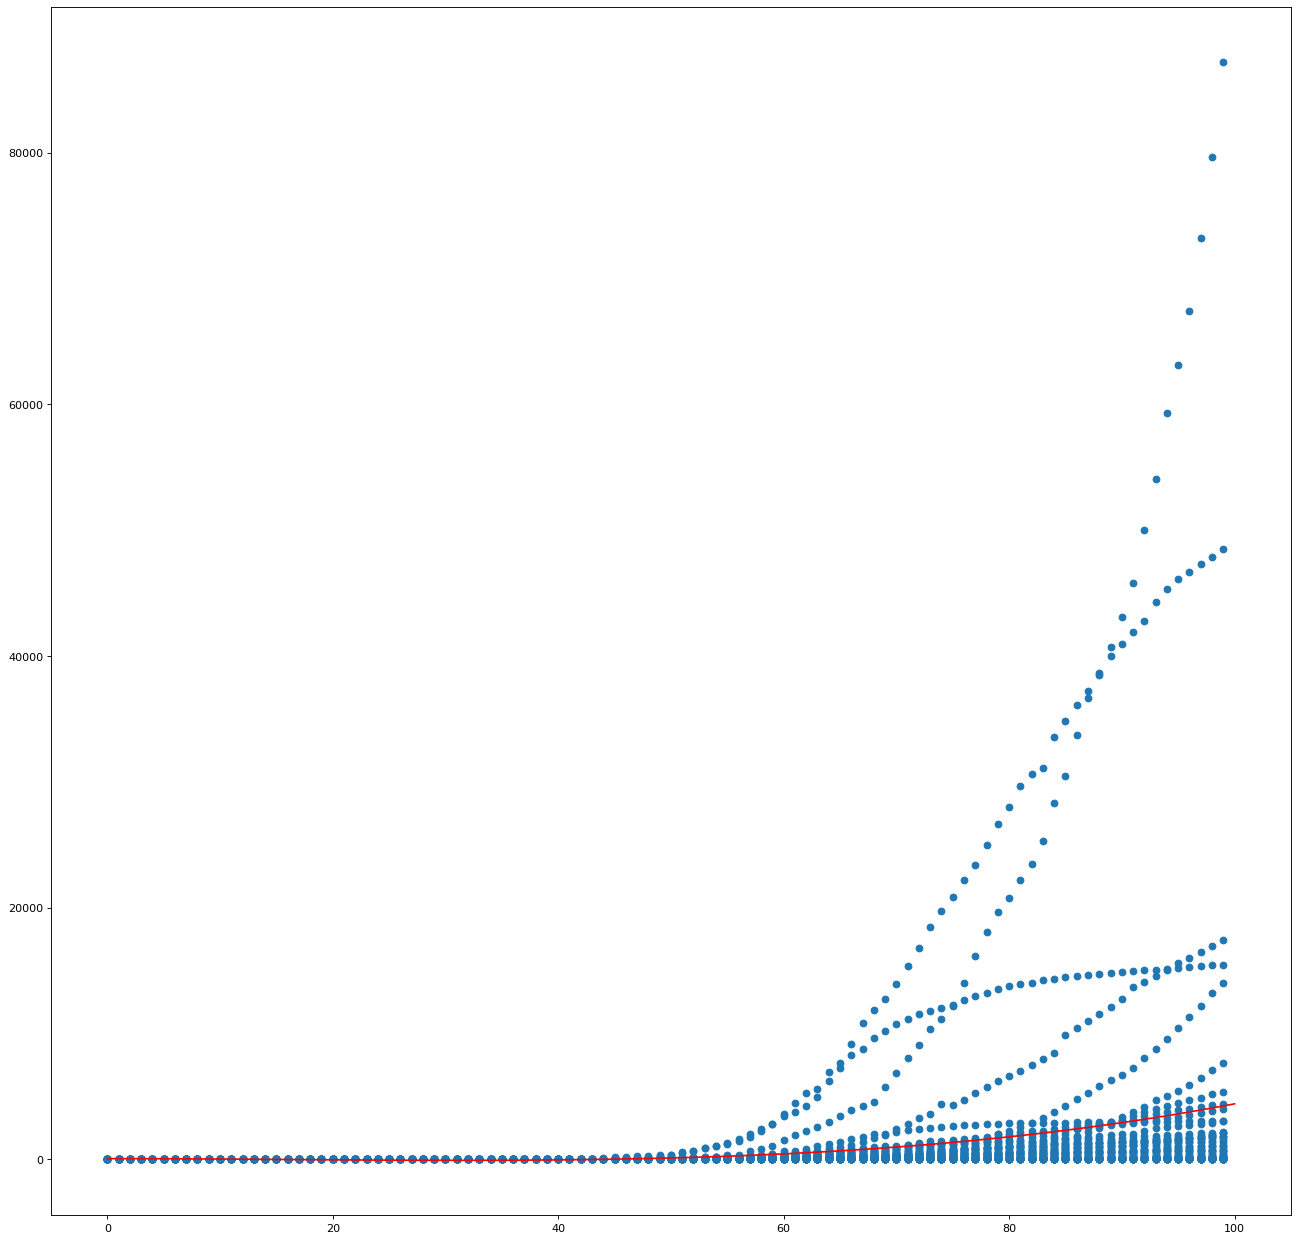

In [ ]:
# 1D polynomial regression
model = np.poly1d(np.polyfit(np.transpose(X_train_1[:,2]), np.transpose(y_train[:,0]), 3))

model_x = np.linspace(0, 100, 100)
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.plot(model_x, model(model_x),'r')
plt.show()

In [ ]:
#Assignment: Report the mean squared error for prediction using differnt degrers of Polynomial Regression
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#1. Report the best model for this data

#2. Repeat for complete data (Change step 3) and report the best model



# **Summary and Discussion (10-15 min session at end of Assignment)**
## This exercise is meant to get us all acquainted with Google colab, porting data from google drive to colab and visualizing outcomes. At the end, discuss the following:
1.  Are there any other ways of pre-processing the data with pandas? What commands would you use?
2. How would you optimize the process? i.e. How would you ensure best fit polynomial regresison is selected. Think of the process/steps. 
3. What does the output metric tell you? Can you gauge over-prediction and udner predictions?


# Answers to Assignment Questions
1. Are there any other ways of pre-processing the data with pandas? What commands would you use?

Ans: We can pre-process the dat in different ways with pandas. The following is one the way to pre-process the dat without defining the 'dat_mat'. The input X=[x1, x2, x3] and the output Y is developed using the 'data_new' dataframe.

In [ ]:
# Let's create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
days=range(0, data_new.shape[1])
X=np.zeros((data_new.shape[0]*data_new.shape[1],3))
Y=np.zeros((data_new.shape[0]*data_new.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_new=np.array(data_new)
for r in range(data_new.shape[0]): #all locations
  X[r*data_new.shape[1]:r*data_new.shape[1]+data_new.shape[1],0]=lat_long[r,0]*np.ones((data_new.shape[1],)) #setting Latitude
  X[r*data_new.shape[1]:r*data_new.shape[1]+data_new.shape[1],1]=lat_long[r,1]*np.ones((data_new.shape[1],)) #setting Longitude
  X[r*data_new.shape[1]:r*data_new.shape[1]+data_new.shape[1],2]=np.reshape(days,(data_new.shape[1],)) #setting the date
  Y[r*data_new.shape[1]:r*data_new.shape[1]+data_new.shape[1]]=np.reshape(data_new[r,:],((data_new.shape[1],1)))

In [ ]:
print(np.shape(X))
#Data Preparation is Done!

(5000, 3)


(5000, 3)


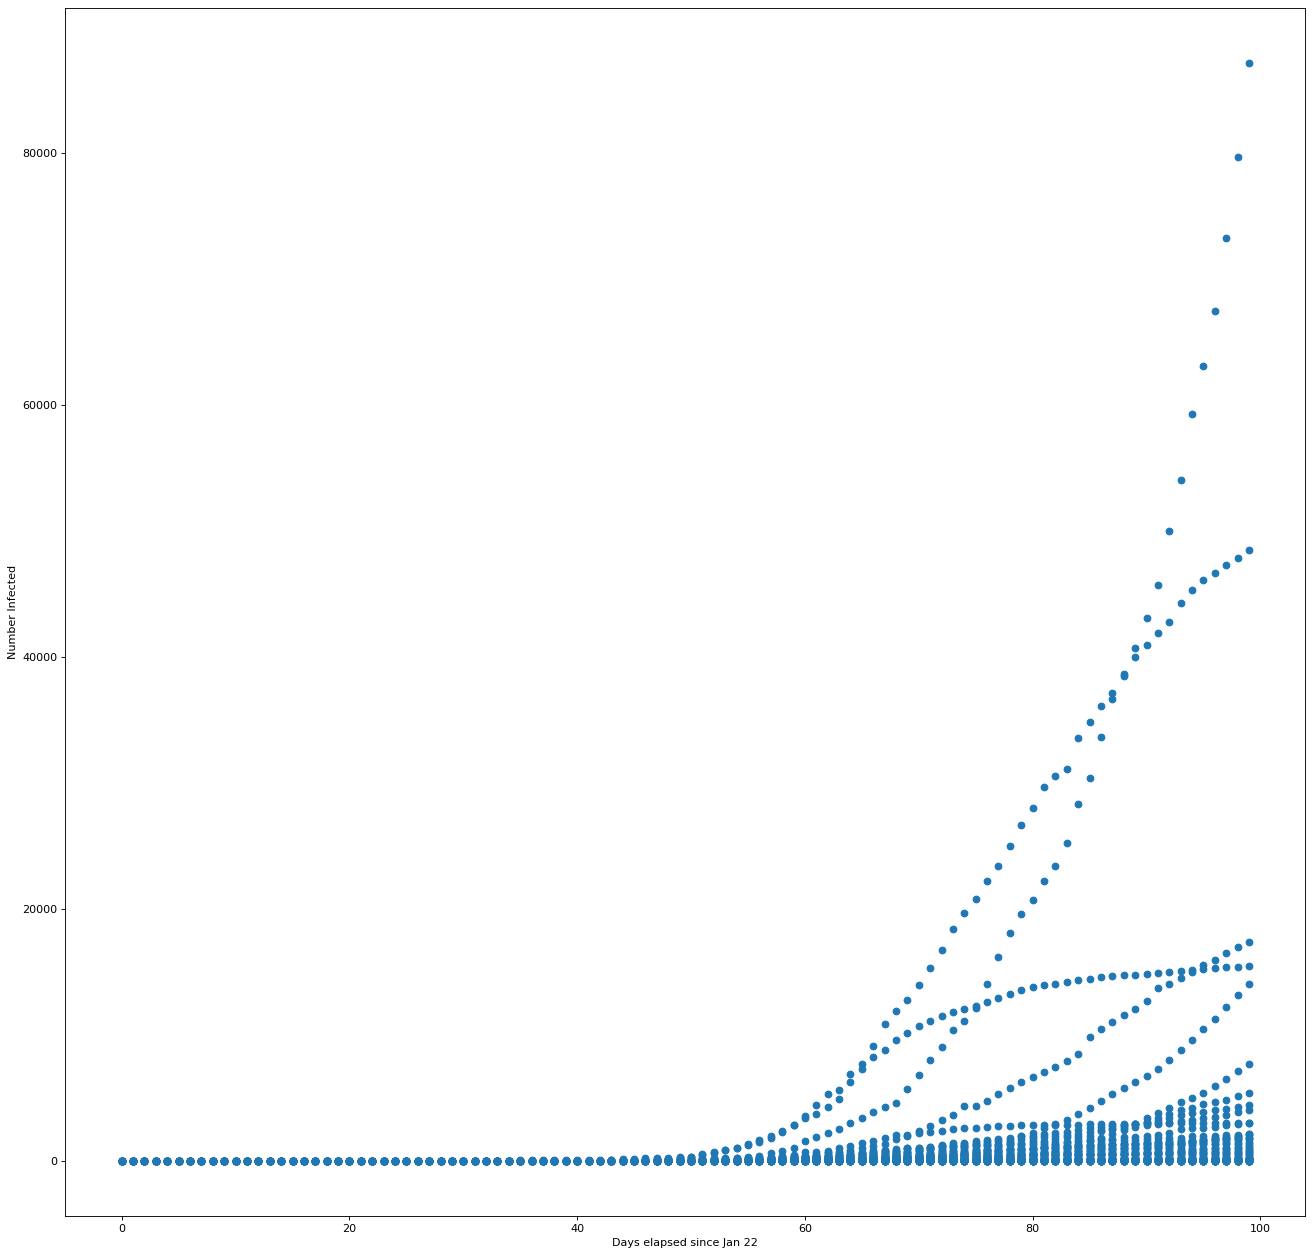

In [ ]:
#Let's Plot the Data to see the converted Data format!
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.xlabel('Days elapsed since Jan 22')
plt.ylabel('Number Infected')
print(np.shape(X))

2. How would you optimize the process? i.e. How would you ensure best fit polynomial regresison is selected. Think of the process/steps.
Ans: We can optize the process by identifying the suitable higher order polynomial regression model which will give the leat MSE on testing data as well as on the training data and both are close to each other (i.e. the right fit to the data). 
After checking with different degrees of the polynomials, polynomial features of degree = 13 is giving the best regression model for the given dataset.

In [ ]:
# Split data into train and test (70% train and 30% test)
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

#Let's fit Polynomial features of degree 3 to the features.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3)
# Transform both the train and test data
X_train = poly.fit_transform(X_train_1)
X_test = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf = LinearRegression()
# Fit the model on train data only
clf.fit(X_train, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

# Predict regression outcome on test data and train data as well
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

#Estimate mse on both trai and test data
from sklearn.metrics import mean_squared_error as mse
print('mse on test dat:', mse(y_test, y_pred_test))
print('mse on train dat:', mse(y_train, y_pred_train))

New shape of test data= (1500, 20)
Linear Regression Coefficients are= [[ 0.00000000e+00  1.49472285e+00 -1.77011169e+01 -7.44377620e+00
  -2.62371164e+00 -1.66783679e-01 -1.32523607e+00  1.32613637e-01
   1.60019698e-01 -5.80740444e-01  4.74622499e-02  8.72080430e-03
   4.50831003e-02 -2.04127549e-03  1.26028661e-02  2.75122310e-03
   2.97102909e-04 -9.33173379e-04 -3.45730697e-03  9.73845530e-03]]
constant coefficient= [515.00766133]
mse on test dat: 20560548.002745174
mse on train dat: 13951414.984562509


In [ ]:
#Let's fit Polynomial features of degree 13 to the features.

poly = PolynomialFeatures(degree=13)
X_train = poly.fit_transform(X_train_1)
X_test = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf = LinearRegression()
clf.fit(X_train, y_train)
#print("Linear Regression Coefficients are=",clf.coef_)
#print("constant coefficient=",clf.intercept_)

y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print('mse on test dat:', mse(y_test, y_pred_test))
print('mse on train dat:', mse(y_train, y_pred_train))

New shape of test data= (1500, 560)
mse on test dat: 42823.76465792344
mse on train dat: 32452.439272987827


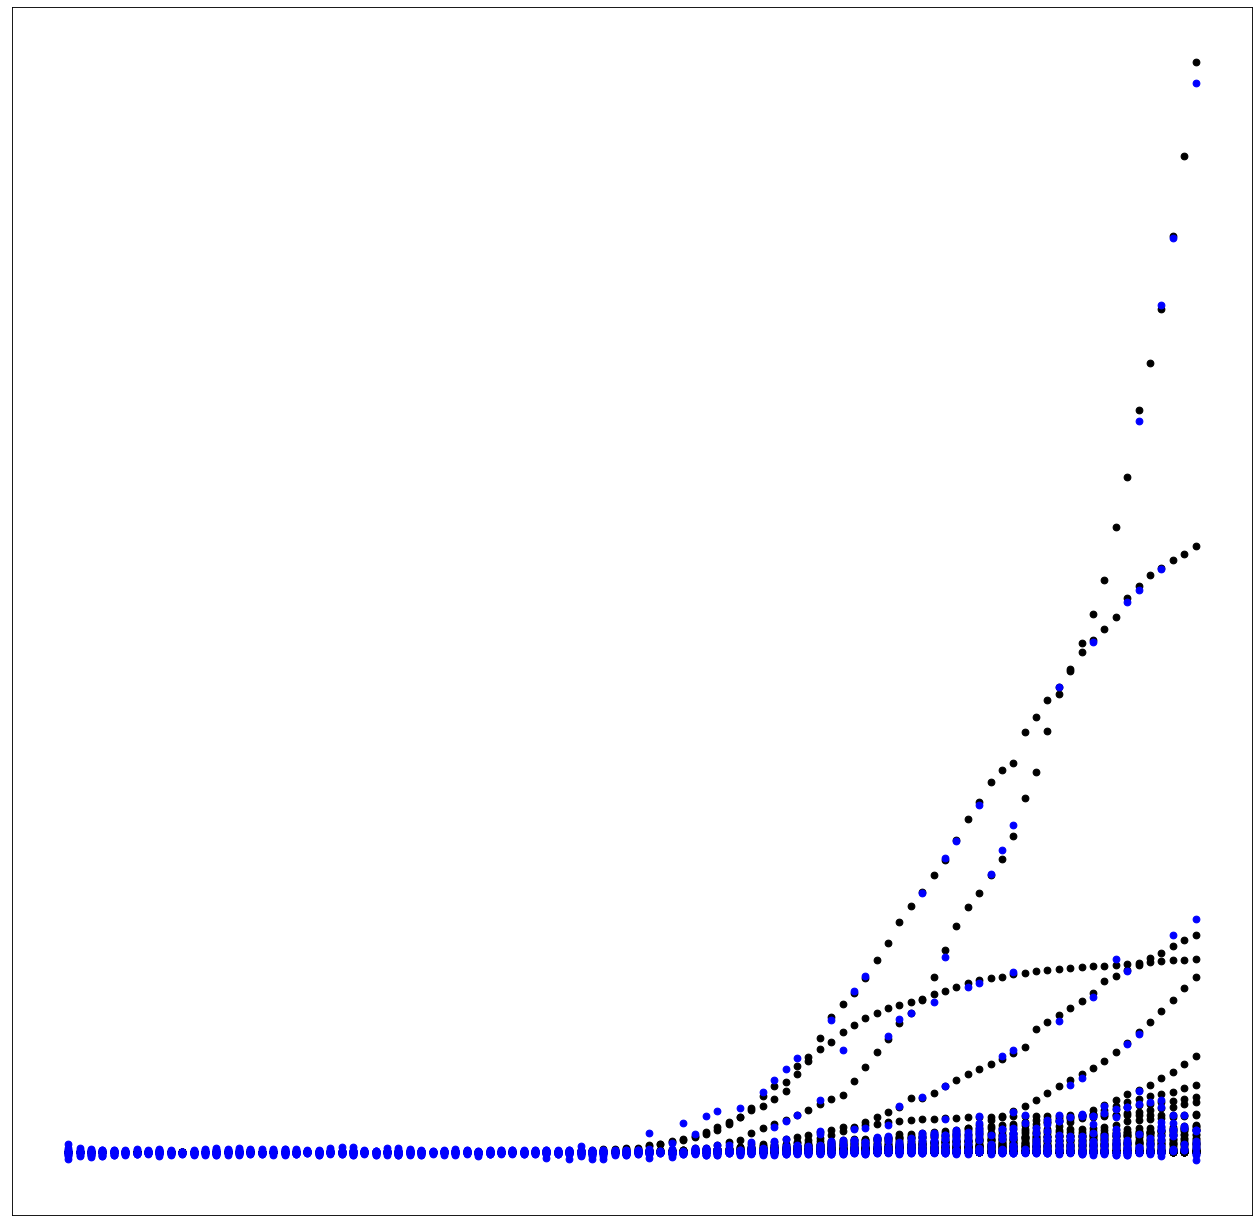

In [ ]:
# next plot predictions
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred_test, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

3. What does the output metric tell you? Can you gauge over-prediction and udner predictions?

Ans: The output metric 'mse' tells about the accuracy of the model. The lower the 'mse', the best the model. We can gage the over-prediction and under-prediction based on the training and testing errors. If the trining error is low and the testing error is high, then the model is over-prection (or high variance). If the training error is high and the testing error is low, then the model is under-prediction (i.e. high bias). If the training error and testing error both are low and close to each other, the model is considered as just right-fit to the given data.     